## Control Feature Theory 

We want to determine a redundant control space from data taken during natural activity. The difficulty with this is that such a natural activity manifold may display spatial (channel-wise) correlations that are possibly physiologically separable. Thus, there are two aims which must be addressed separately:
1. Expore subjects' ability to decorrelate descending output to the muscles which have been shown to be correlated in a natural activity dataset. 
    - Such a structured exploration might provide support for the hypothesis that "synergies" are flexible correlations between muscles driven by task demands rather than (or in addition to) physiological structure. This needs to be done incredibly carefully to escape criticism of hard-wired synergy enthusiasts. 
    - See *de Rugy 2012* for a critique of OFC and hard-wired synergies
2. Use common correlated outputs to develop a family of BMI-type learning tasks as a proxy for a "novel skill", then track motor planning of this new skill to compare with motor planning algorithms. 
    - We might be able to get #1 for free by going after this goal if we're careful in the setup
    - This is arguably a more impactful focus as it connects low-level motor hierarchy data (EMG) to high-level planning with a normative hypothesis. 

### Unsupervised Feature Extraction 

Electrode data from a single trial of a single session is held in a data matrix $X$ (n_electrodes, n_samples), and we wish to find a latent weight matrix $W$ (n_electrodes, n_components) which reconstructs $X$ by projecting latent trajectories $H$ (n_components, n_samples) into electrode space: 

$$
X = W\cdot{H}
$$

$H$ is the activity of the latent processes, and $W$ is there mixing matrix. The columns of $W$ are the principal vectors spanning the latent subspace in electrode space. If we have new samples, we can project these new points onto this subspace:

$$
h_{new} = W^T\cdot{w_{new}}
$$

To justify this decomposition, we have to make some assumptions about the nature of the EMG signal, namely that the signal is linear instantaneous (each EMG sample can be instantly mapped to control space). The other assumption is that the basis $W$ should be orthonormal, that the columns of $W$ are orthogonal with unity norm. This ensures that the left inverse $W^{-1}$ is equal to the transpose $W^T$ such that: 

$$
\begin{align}
X &= W\cdot{H} \\ 
W^{-1}\cdot{X} &= {H} \\
W^{T}\cdot{X} &= {H} \\
\end{align}
$$

See *Muceli 2014* for use of the Moore-Penrose pseudoinverse in place of the transpose when the columns of $W$ do not form an orthonormal basis. This would be the case for NMF. Is there a factorization that produces nonnegative, orthogonal coordinates? Or is the pseudoinverse okay? I will need to test this. 

To find such a basis, we must do the following: 
- Extract "natural activity manifold" from freeform data
- Use features of this natural subspace to derive control mapping
    - Linear iid features:
        - PCA
        - NMF
        - ICA 
    - Linear time-dependent features:
        - SSA
        - LDS model / PGM
    - Nonlinear
        - autoencoders
        - networks

The behaviors present in our calibration dataset are crucial, as they determine the spatial correlations used to generate the mapping. If only complex, multi-muscle movements are present in the calibration, it will be impossible to decode subtle movements involving few muscles. Additionally, because extraction is unsupervised, it will be impossible to know how to alter the control basis directions (if we wish to do so) such that they involve single muscles or the smallest sets of muscles. 

Ultimately, we want to find reproducible features in our data that are do to muscle coordination alone, rather than volitional movements. We want the lowest level covariance that reflects physiology rather than a task-level behavioral description (see *Todorov, Ghahramani 2005* and *Ingram, Wolpert 2009*). The idea is that if we collect data from enough tasks, we can extract the common modes of muscle activity. This is true only if we are sampling uniformly from the space of tasks. Otherwise one task, and therefore one coordination pattern, will be overrepresented. 

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = [9, 6]
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
import numpy as np
import scipy.signal
import scipy.ndimage
import seaborn as sns
import pandas as pd 
from pathlib import Path

## Functions

In [9]:
def plot_biolectric_with_fft(data, idxs_to_plot):
    fig = plt.figure()
    num_plots = len(idxs_to_plot) * 2
    for i, idx in enumerate(idxs_to_plot):
        ax = fig.add_subplot(num_plots, 1, 2 * i + 1)
        ax.plot(data[idx])
        # Number of samplepoints
        N = 2000
        # sample spacing
        T = 1.0 / 2000.0
        x = np.linspace(0.0, N * T, N)
        yf = scipy.fftpack.fft(data[idx])
        xf = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)
        ax_fft = fig.add_subplot(num_plots, 1, 2 * i + 2)
        ax_fft.plot(xf[:100], 2.0 / N * np.abs(yf[:N // 2][:100]))
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.1, hspace=0.3)
    return fig

def highpass(sig, cutoff=50):
    b, a = scipy.signal.butter(4, cutoff, 'highpass', analog=False, fs=2000)
    return scipy.signal.filtfilt(b, a, sig, axis=0)

def lowpass(sig, cutoff=500):
    b, a = scipy.signal.butter(4, cutoff, 'lowpass', analog=False, fs=2000)
    return scipy.signal.filtfilt(b, a, sig, axis=0)

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

## this is the layout of the BACK of the gridarray
def grid_layout(data, grid_type = '8x8'):
    """
        transforms data into electrode layout
        data should be in [feature, sample] format
    """
    if len(data.shape) != 2:
        raise ValueError("data must be 2D")
    if grid_type == '8x8':
        pin_layout = np.array([
         [8, 16, 24, 32, 40, 48, 56, 64], 
         [7, 15, 23, 31, 39, 47, 55, 63],
         [6, 14, 22, 30, 38, 46, 54, 62],
         [5, 13, 21, 29, 37, 45, 53, 61],
         [4, 12, 20, 28, 36, 44, 52, 60],
         [3, 11, 19, 27, 35, 43, 51, 59],
         [2, 10, 18, 26, 34, 42, 50, 58],
         [1,  9, 17, 25, 33, 41, 49, 57]
         ])
        pin_layout = pin_layout-1
    output = np.zeros((pin_layout.shape[0],pin_layout.shape[1],data.shape[1]))
    for i, row in enumerate(pin_layout):
        for j, og_idx in enumerate(row):
            output[i,j,:] = data[og_idx,:]
    return output

def preprocess(data):
    data_mv = data*0.0002861
    data_mv -= np.mean(data_mv, axis=0)
    print("max: ",np.max(data_mv),"min: ",np.min(data_mv))
    print("shape: ",data_mv.shape)
#     data = highpass(data)
#     data = lowpass(data)
#     print("max",np.max(data),"min",np.min(data))
    return data_mv

def plot_biolectric(data, idxs_to_plot=None, offset=1, freq=2000):
    fig, ax = plt.subplots(figsize=(15, 10))
    if idxs_to_plot is None:
        idxs_to_plot = list(range(data.shape[0]))
    t = np.linspace(0, data.shape[1]/freq, data.shape[1])
    for i, idx in enumerate(idxs_to_plot):
        ax.plot(t, data[idx] + (i+1) * offset)
    ax.set_yticks([(i+1)*offset for i in range(len(idxs_to_plot))])
    ax.set_yticklabels([str(idx+1) for idx in idxs_to_plot],FontSize=12)
    ax.set_ylabel("Channel")
    ax.set_xlabel("Time [s]")
    return fig

def plot_counter(counter):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(counter)
    # this should be 0 or the number of dropped
    # samples at the previous timepoint. 
    drops = (counter[1:] - counter[:-1])-1
    print(np.where(drops==-(2**16)))
    drops[np.where(drops==-(2**16))] = 0
    ax.plot(drops)
    for idx in np.where(drops!=0):
        print(f"Dropped {drops[idx]} samples at {idx}")
    fig.suptitle("Device Sample Counter")
    return fig, ax

def plot_psd(data, freq=2000, legend=False, fig=None):
    dim = len(data.shape)
    if fig == None:
        fig = plt.figure()
    
    if dim == 2:
        for i, channel in enumerate(data):
            plt.psd(channel, Fs=freq, detrend='linear', label="Channel "+str(i))
            if legend:
                plt.legend()
    elif dim == 1:
        plt.figure()
        p = plt.psd(data, Fs=freq, detrend='linear', label='PSD')
    else:
        raise ValueError("data array must be 1D or 2D")

def load_from_file(filepath, nch, dtype, order="C"):
    with open(filepath, 'rb') as f:
        data = np.fromfile(f, dtype=dtype)
    return data.reshape(-1, nch).T

def plot_features_grid(features, layout='8x8',vmin=0,vmax=1):
    n_features = features.shape[0]
    components = features[:n_features].T
    griddata = grid_layout(components)
    fig = plt.figure(figsize=(16,4))
    axs = fig.subplots(1, n_features)
    for ax, (i, img) in zip(axs,enumerate(griddata.T)):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(0)
        ax.set_title("Component "+str(i+1))
        im = ax.imshow(img,vmin=vmin, vmax=vmax)
    fig.subplots_adjust(right=0.8)
    fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', pad=0.05, shrink=0.6)
    return fig 

def tree(directory):
    print(f'+ {directory}')
    for path in sorted(directory.rglob('*')):
        depth = len(path.relative_to(directory).parts)
        spacer = '    ' * depth
        print(f'{spacer}+ {path.name}')

## Files

In [201]:
folder = Path("200320_spencer")
g = folder.glob('*')
data_files = [x for x in g if x.is_file() and x.suffix=='.data']
# tree(folder)
print("DATA FILES:")
for file in data_files:
    print(f"+ {file}")

DATA FILES:
+ 200320_spencer/fingers_belowtable_weak.data
+ 200320_spencer/fingerflexions_2.data
+ 200320_spencer/strong_grasp.data
+ 200320_spencer/freeform.data
+ 200320_spencer/fingers_belowtable_strong.data
+ 200320_spencer/fingers_abovetable_strong.data
+ 200320_spencer/fingers_abovetable_weak.data
+ 200320_spencer/fingerflexions_1.data


## Noise
This is the sample electrode placement as all the other datasets, but without any motion at all. 

max:  0.010594640624999999 min:  -0.01099696875
shape:  (64, 111670)
(array([65034]),)
Dropped [] samples at []


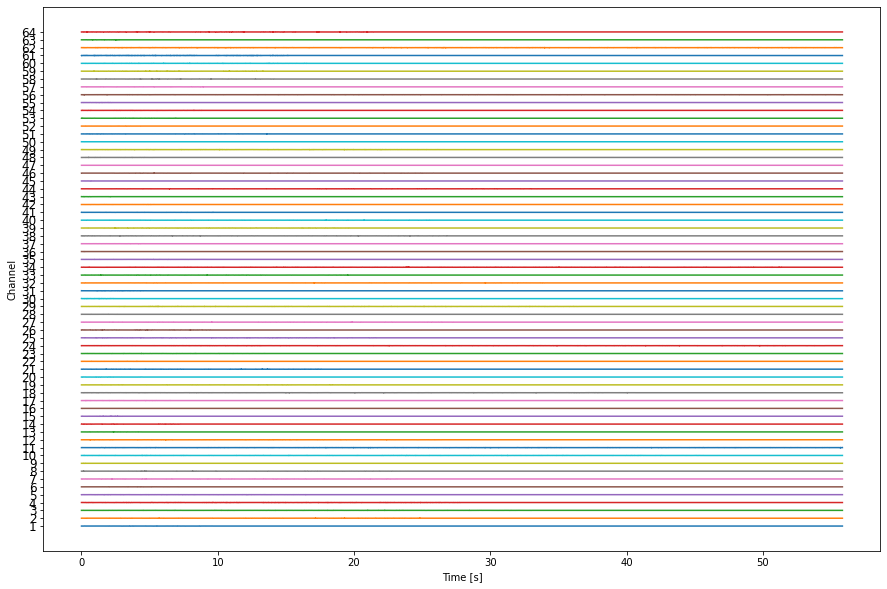

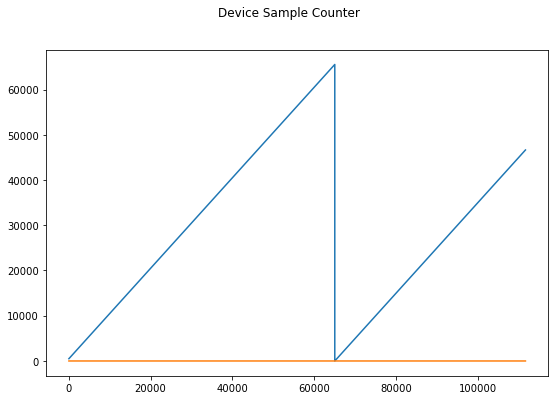

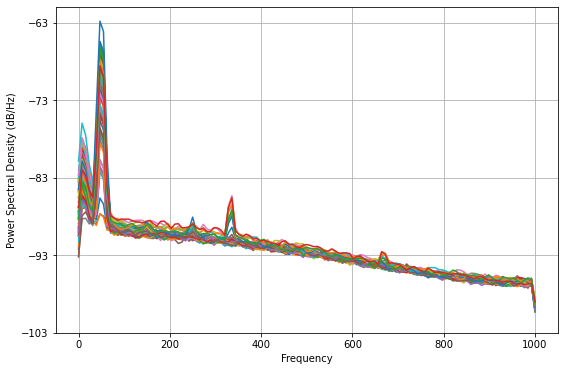

In [17]:
filename = "quiescent.data"
path = folder / filename
# chop into relevant time series pieces
START_SAMPLE = 500
data = load_from_file(path, nch=68, dtype="int32")[:,START_SAMPLE:]
signals = data[:64]
counter = data[-1]
data_mv = preprocess(signals)
s_fig = plot_biolectric(data_mv, offset = 1)
c_fig = plot_counter(counter)
f_fig = plot_psd(data_mv)

Note that "below table" has considerably less noise... 

## "Natural" Activity 

Analysis of data collected with the 8x8 grid on 20/03/20. These electrodes are 2mm diameter and spaced 4mm apart. Grid was attached to the underside of the arm, rotated 90deg. Assuming activity recorded from flexor carpi ulnaris, palmaris longus... hard to tell. Movements were light flexions of each finger in succession. Assuming there is quite a lot of line noise in the recording. 

max:  0.2725504828125 min:  -0.6962779937500001
shape:  (64, 169875)
(array([ 64534, 130070]),)
Dropped [] samples at []


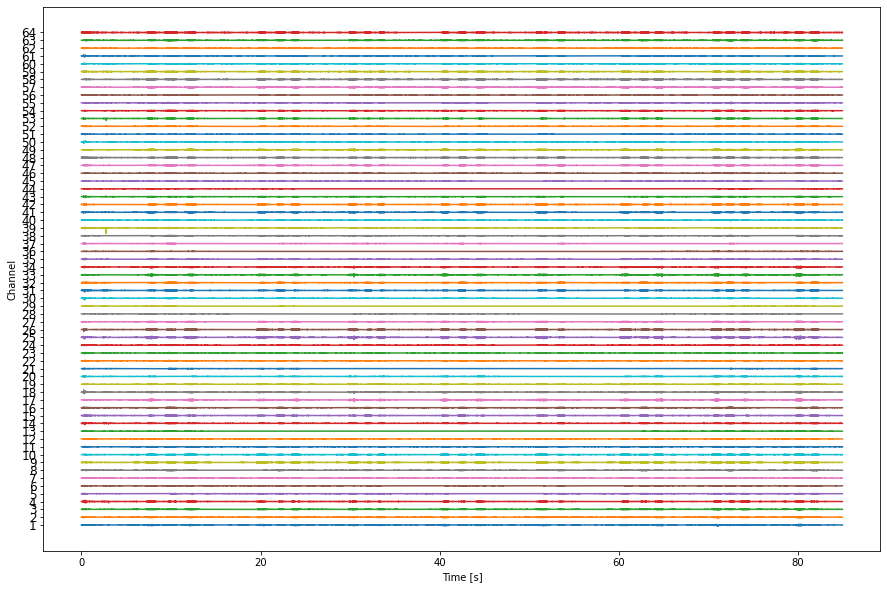

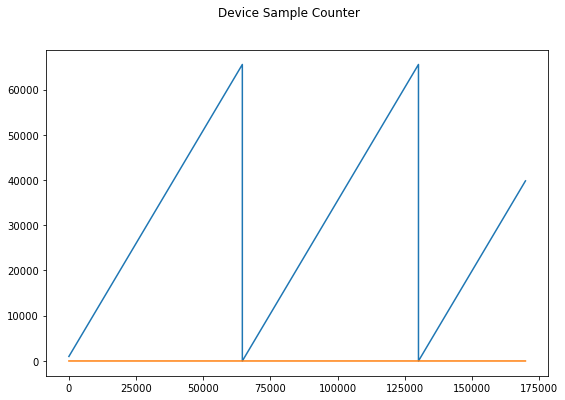

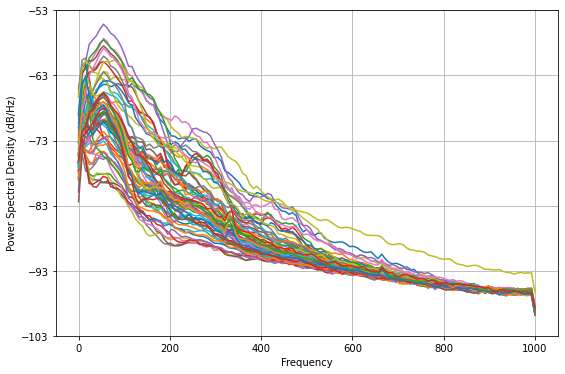

In [18]:
filename = "fingers_belowtable_weak.data"
path = folder / filename
# chop into relevant time series pieces
START_SAMPLE = 1000
data = load_from_file(path, nch=68, dtype="int32")[:,START_SAMPLE:]
signals = data[:64]
counter = data[-1]
data_mv = preprocess(signals)
s_fig = plot_biolectric(data_mv, offset = 1)
c_fig = plot_counter(counter)
f_fig = plot_psd(data_mv)

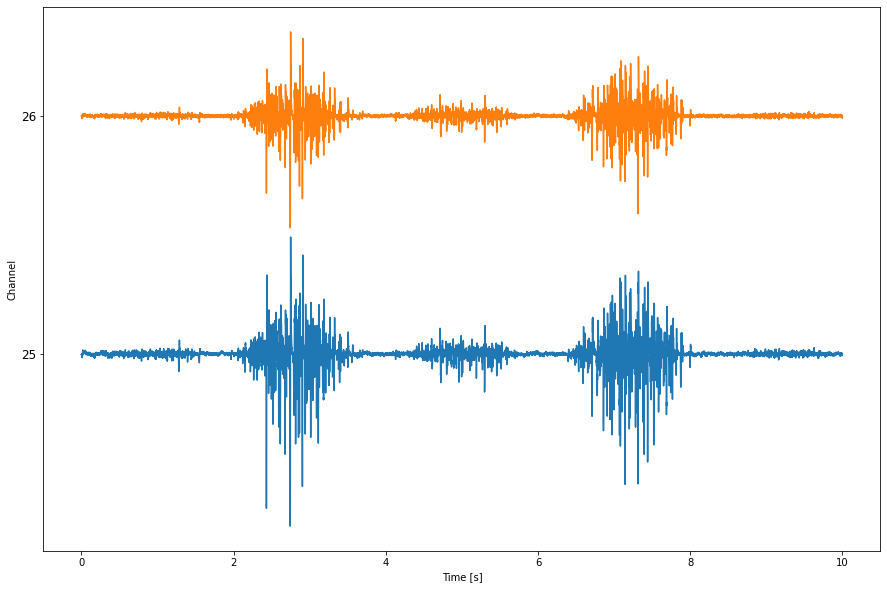

In [26]:
# zoom in on a few channels 
freq=2000
fig = plot_biolectric(data_mv[:,5*freq:15*freq], idxs_to_plot = [24,25], offset = .3)

## PCA
PCA treats samples as if they are iid. We can whiten each channel before computing PCA in order to not weight one dimension over another due only to its magnitude rather than it's covariance with other traces. 

#### Scaling / Standardizing
I'm testing the effects of standardizing each trace to have zero mean and unity variance. 

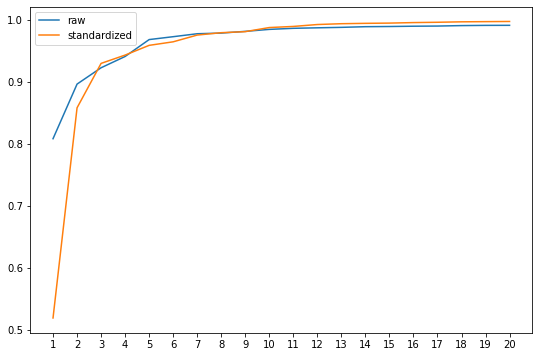

In [19]:
ncomps=20
scaler = StandardScaler()
pca = PCA()
# scale each time series 
# scaler takes (features, samples)
scaled = scaler.fit_transform(data_mv)
# model takes (samples, features)
pca.fit(scaled.T)  
plt.plot(range(1,ncomps+1),1 - pca.explained_variance_ratio_[:ncomps],label="raw")
plt.xticks(range(1,ncomps+1))

pca_unscaled = PCA()
pca_unscaled.fit(data_mv.T)  
plt.plot(range(1,ncomps+1),1 - pca_unscaled.explained_variance_ratio_[:ncomps],label="standardized")
plt.xticks(range(1,ncomps+1))
plt.legend()

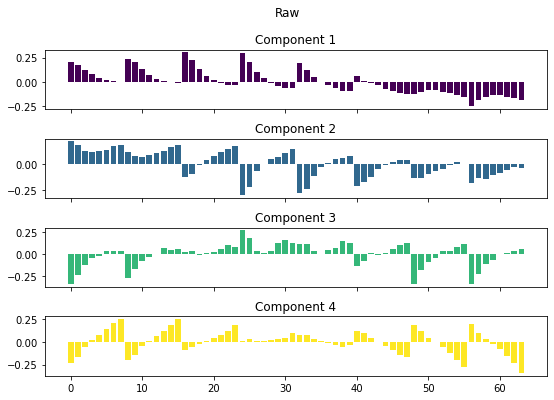

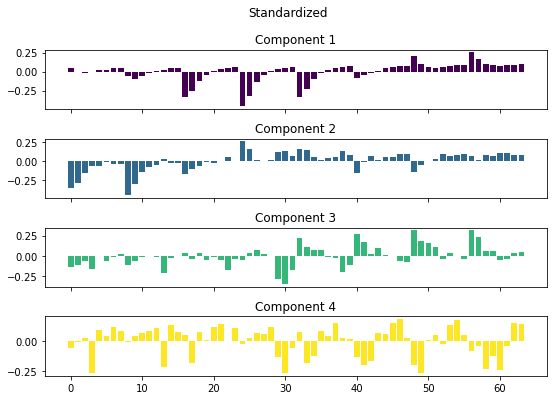

In [20]:
def plot_features_bar(feature_vecs):
    fig = plt.figure()
    n_features = feature_vecs.shape[0]
    cm = get_cmap(n_features,'viridis')
    axs = fig.subplots(n_features,1,sharex=True)
    fig.subplots_adjust(hspace=0.5)
    for i, ax in zip(range(n_features),axs):
        ax.bar(range(len(feature_vecs[i].T)),feature_vecs[i].T, color=cm(i))
        ax.set_title(f"Component {i+1}",FontSize=12)
    return fig 

fig = plot_features_bar(pca.components_[:4])
_ = fig.suptitle("Raw")
fig = plot_features_bar(pca_unscaled.components_[:4])
_ = fig.suptitle("Standardized")

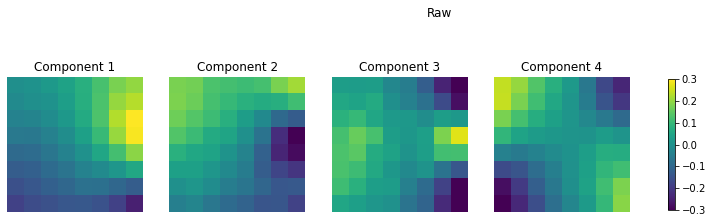

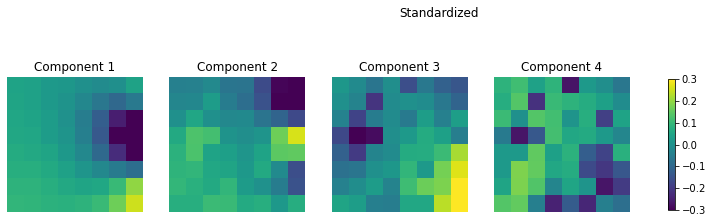

In [21]:
fig = plot_features_grid(pca.components_[:4],vmin=-.3,vmax=0.3)
_ = fig.suptitle("Raw")
fig = plot_features_grid(pca_unscaled.components_[:4],vmin=-.3,vmax=0.3)
_ = fig.suptitle("Standardized")

In [22]:
# sanity check
# eigenvector basis is orthonormal, therefore inv(A) = A.T 
np.dot(pca.components_[:4],pca.components_[:4].T)

array([[ 1.00000000e+00, -3.98363167e-17, -9.30657617e-17,
        -1.08958903e-16],
       [-3.98363167e-17,  1.00000000e+00, -4.65452864e-17,
         5.17110233e-17],
       [-9.30657617e-17, -4.65452864e-17,  1.00000000e+00,
         2.96039815e-16],
       [-1.08958903e-16,  5.17110233e-17,  2.96039815e-16,
         1.00000000e+00]])

# PCA Takeaways 

- Since all of our features share the same scale, standardization should not be required... 
    - Is it interesting that the scaled and unscaled features look very different...?
    - This is very dependent on dataset, some sets show cleaner features when standardized. 
- The scale of the data is worrisome... 
    - Values are getting quite small
    - This could be fixed by doing MinMax standardization
- We want features that are: 
    - essentially spatial filters that we can match for decoding 
    - smooth; having low spatial frequency 
    - equal in the variance that they capture; equally likely to exist in future data
        - Perhaps use CCA to find N features that are maximally dissimilar?
        - Use ICA to find independent features?
    - existent in natural activity; intuitive 
- We should be careful to normalize feature vectors to interpret the output of our filter as a correlation 
- Processing is important to extract relevant features. 
- PCA attempts to describe the covariance by successive features, we want a predefined number of features that meet our criteria and share as much of the variance as possible. PCA might be a first step for denoising the data. 

### Todo
- How does PCA relate to NMF/ICA/FA mathematically (PGM explanation?)
    - How does the PGM interpretation drive a principled choice for the decoder?
    - Can we derive our required features via optimization? 
- Develop a preprocessing pipeline 
    - Rectification
    - Low pass filtering / smoothing / averaging
    - max/min normalization onto [0,1] to constrain control range 
        - how do we define max/min? a separate maximum contraction calibration? 
- cross-validate the control features
    - within session (holdout)
    - cross session (slight changes in electrode placement)
- do we care at this point about temporal correlations? 
    - in playing with the basic task, it is interesting to note how it is nontrivial to "hold" activity at a desired level-- it is difficult for me to sustain tonic firing, and i tend to end up with phasic bursts. 
    - this says something about a method like SSA for example: much of the temporal features might be volitional. 

In [176]:
sanity_check = """
# components_ is the model basis
# this: 
projection = pca_unscaled.transform(data_mv[:,:3].T)
print(projection[:,:4].shape)
fig = plot_features_bar(projection[:,:4])
# is the same as: 
components = pca_unscaled.components_[:4]
projection_ = (data_mv[:,:3]).T.dot(components.T)
print(projection_.shape)
fig = plot_features_bar(projection_)
"""

### With Preprocessing 

I'll try rectifying and lowpassing the signals and see what happens. This is standard procedure from the literature, though the cutoff frequency has been shown to be have a nonlinear impact on the reconstruction error

In [189]:
def moving_average(a, window_length=100) :
    return scipy.ndimage.convolve1d(a, np.ones((window_length)),axis=1,mode='nearest')/window_length

def blur(a, sigma=50):
    return scipy.ndimage.gaussian_filter1d(a, sigma=sigma ,axis=1,mode='nearest')

# plt.figure()
# sig = np.ones((2,1000))
# sig[:, sig.shape[1]//2:] = -1
# print(sig.shape)
# for i, s in enumerate(sig):
#     plt.plot(s)
# plt.suptitle("sig")

# plt.figure()
# sigavg = moving_average(sig,window_length=200)
# print(sigavg.shape)
# for i, s in enumerate(sigavg):
#     plt.plot(s)
# plt.suptitle("avg")

# plt.figure()
# sigavg = blur(sig,sigma=70)
# print(sigavg.shape)
# for i, s in enumerate(sigavg):
#     plt.plot(s)
# plt.suptitle("blur")

In [185]:
filename = "fingers_belowtable_weak.data"
path = folder / filename
START_SAMPLE = 500
data = load_from_file(path, nch=68, dtype="int32")[:,START_SAMPLE:]
signals = data[:64]
counter = data[-1]
data_mv = preprocess(signals)
rectified = np.abs(data_mv)
averaged = moving_average(rectified, window_length=250)
blurred = blur(rectified, sigma=50)
# fig = plot_biolectric(data_mv[:,5*freq:15*freq], idxs_to_plot = [23,24,25], offset = .3)
# fig = plot_biolectric(rectified[:,5*freq:15*freq], idxs_to_plot = [23,24,25], offset = .3)
# fig = plot_biolectric(averaged[:,5*freq:15*freq], idxs_to_plot = [23,24,25], offset = .3)
# fig = plot_biolectric(blurred[:,5*freq:15*freq], idxs_to_plot = [23,24,25], offset = .3)
print(data_mv.shape, rectified.shape, averaged.shape, blurred)

max:  0.2725504828125 min:  -0.6962779937500001
shape:  (64, 170375)
(64, 170375) (64, 170375) (64, 170375) [[0.0089499  0.00897111 0.00899263 ... 0.00041593 0.00041121 0.00040651]
 [0.00504507 0.00503049 0.00501604 ... 0.00049005 0.00048375 0.00047747]
 [0.00332868 0.00331339 0.00329812 ... 0.00109682 0.00109914 0.00110149]
 ...
 [0.00414927 0.00415211 0.00415546 ... 0.00083063 0.00082986 0.00082905]
 [0.00242963 0.00244618 0.00246272 ... 0.00103171 0.00103213 0.0010325 ]
 [0.00553966 0.00553481 0.00553005 ... 0.00096437 0.00095724 0.00095006]]


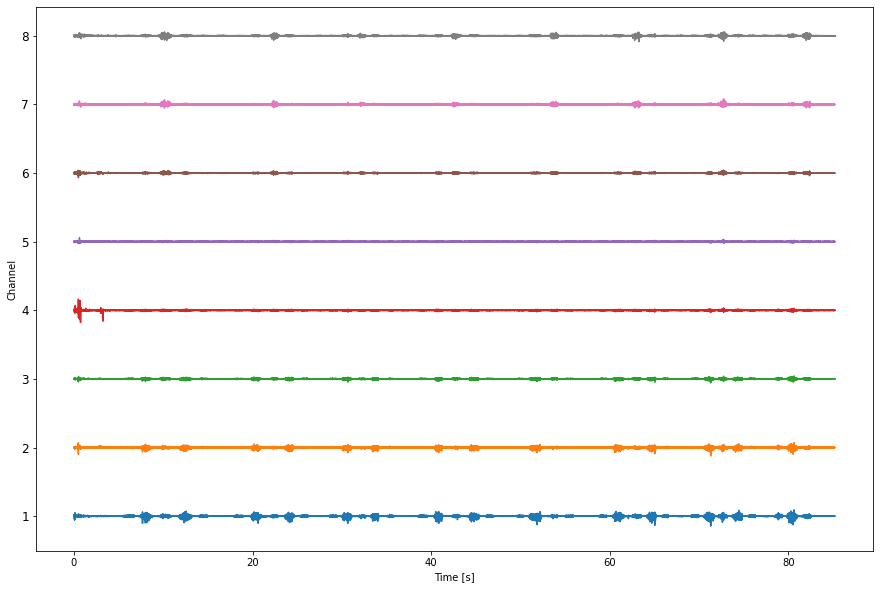

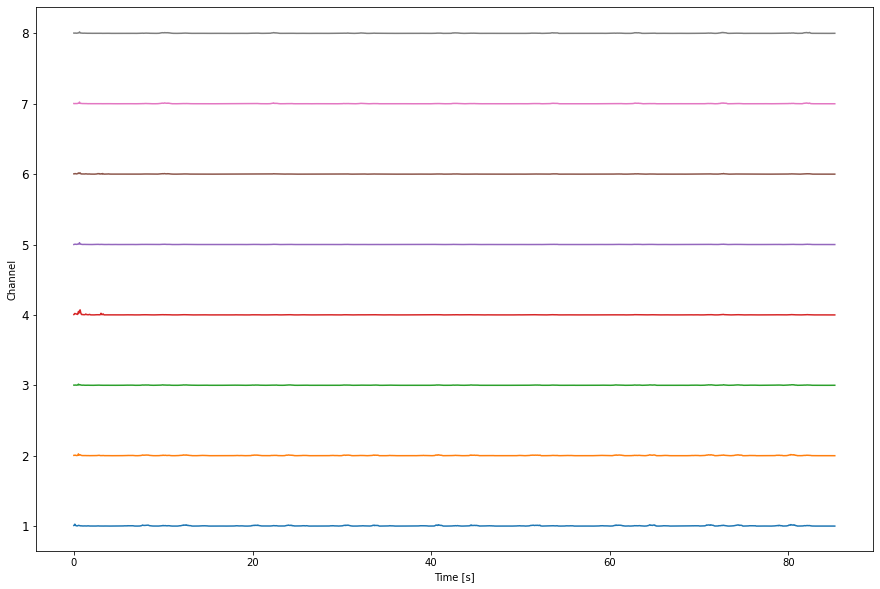

In [186]:
fig = plot_biolectric(data_mv, idxs_to_plot=range(8), offset = 1)
fig = plot_biolectric(blurred, idxs_to_plot=range(8), offset = 1)

## PCA (again) 

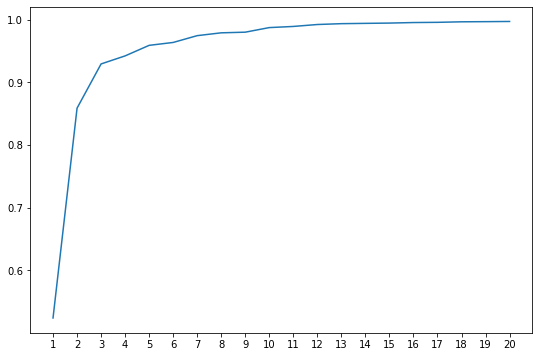

In [187]:
pca = PCA()
# model takes (samples, features)
pca.fit(data_mv.T)  
plt.plot(range(1,ncomps+1),1 - pca.explained_variance_ratio_[:ncomps],label="raw")
t = plt.xticks(range(1,ncomps+1))

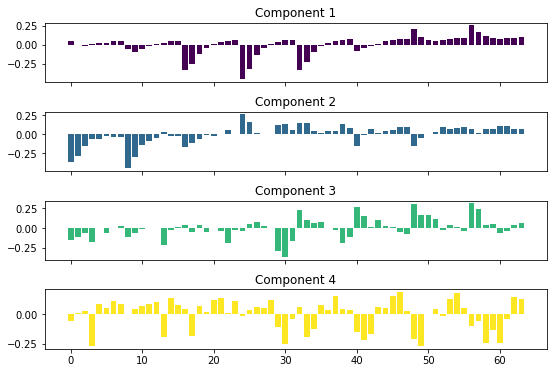

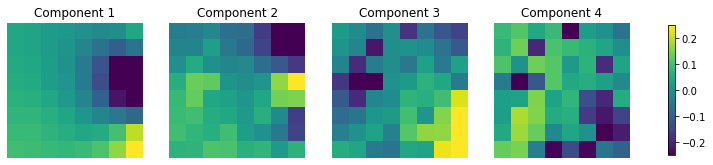

In [188]:
fig = plot_features_bar(pca.components_[:4])
fig = plot_features_grid(pca.components_[:4],vmin=-0.25,vmax=0.25)

## NMF 

Note that the input data must be positive. data_mv

In [167]:
n_nmf_components = 4
nmf = NMF(n_components=n_nmf_components, init='random', random_state=42)
nmf.fit(abs(blurred.T))
# X = WH -- W is fit_transform, H is components_
NMF_components = nmf.components_

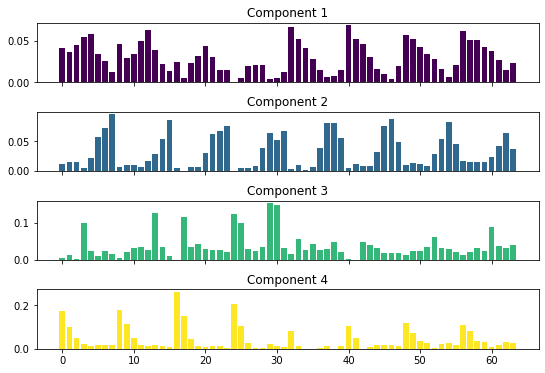

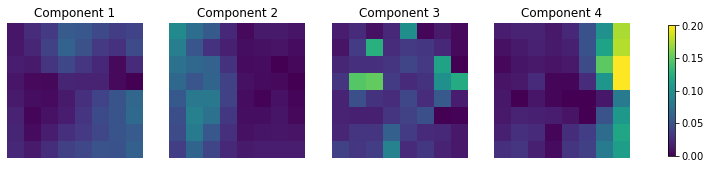

In [169]:
fig = plot_features_bar(NMF_components)
fig = plot_features_grid(NMF_components,vmax=0.2)

## ICA

In [170]:
from sklearn.decomposition import FastICA
n_components = 4
ica = FastICA(n_components=n_components)
ica.fit(blurred.T)
ICA_components = ica.components_
ICA_components.shape

(4, 64)

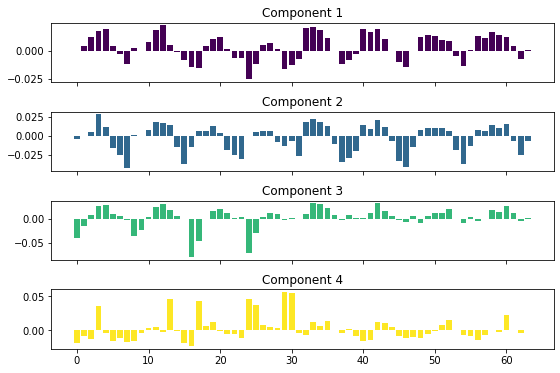

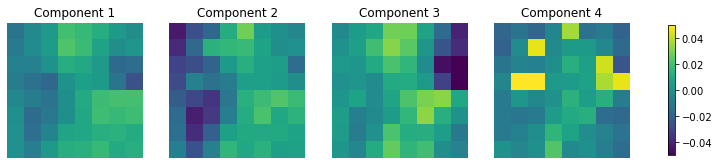

In [171]:
fig = plot_features_bar(ICA_components)
fig = plot_features_grid(ICA_components,vmin=-0.05,vmax=0.05)

## Factor Analysis 

In [172]:
from sklearn.decomposition import FactorAnalysis
n_components = 4
fa = FactorAnalysis(n_components=n_components)
fa.fit(blurred.T)
FA_components = fa.components_
FA_components.shape

(4, 64)

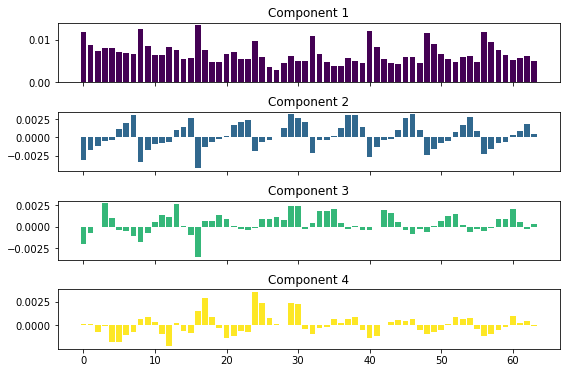

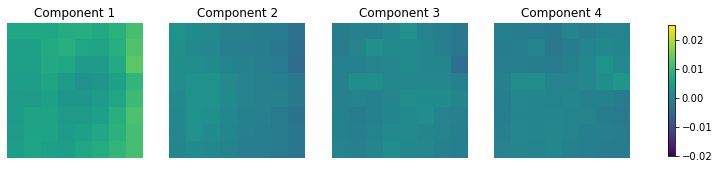

In [175]:
fig = plot_features_bar(FA_components)
fig = plot_features_grid(FA_components,vmin=-0.02,vmax=0.025)

## Concatenating Data
Try to concatenate files to extract common modes from all the recorded data. Think of this like cross-trial decomposition.  

In [243]:
signal_concat = np.empty(shape=(64,0))
for filepath in data_files:
    data = load_from_file(filepath, nch=68, dtype="int32")[:,START_SAMPLE:]
    signal = data[:64]
    data_mv = preprocess(signal)
    rectified = np.abs(data_mv)
    blurred = blur(rectified)
    signal_concat = np.append(signal_concat, blurred, axis=1)
print(signal_concat.shape)

max:  0.2725504828125 min:  -0.6962779937500001
shape:  (64, 170375)
max:  0.48094304062500004 min:  -0.6348246078125
shape:  (64, 292915)
max:  0.578565725 min:  -0.6638458765625
shape:  (64, 141608)
max:  1.5820838265625001 min:  -0.843002590625
shape:  (64, 155003)
max:  0.31062413437499997 min:  -0.38591760781250006
shape:  (64, 226400)
max:  0.33132168125 min:  -0.40913641093750003
shape:  (64, 187818)
max:  0.2817325046875 min:  -0.35802285781250004
shape:  (64, 226343)
max:  0.11865103437500002 min:  -0.188334265625
shape:  (64, 213416)
(64, 1613878)


In [252]:
print(np.min(signal_concat))
print(np.max(signal_concat))
print(np.var(signal_concat, axis=0))
# plot_biolectric(signal_concat[2:6][-1000:])

0.0003113475404851658
0.480629327830094
[1.75779389e-05 1.74132884e-05 1.72506825e-05 ... 4.96273648e-07
 5.05426812e-07 5.14668243e-07]


## PCA (yet again) 

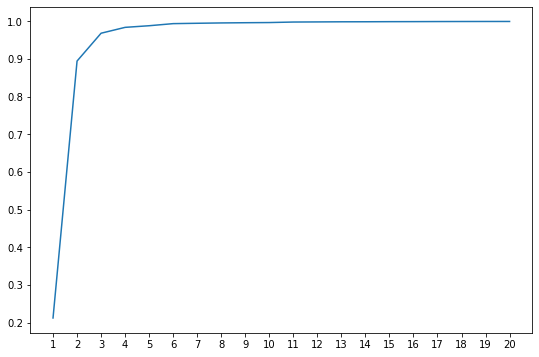

In [245]:
pca = PCA()
pca.fit(signal_concat.T)  
plt.plot(range(1,ncomps+1),1 - pca.explained_variance_ratio_[:ncomps],label="raw")
t = plt.xticks(range(1,ncomps+1))

In [246]:
n_features = 4

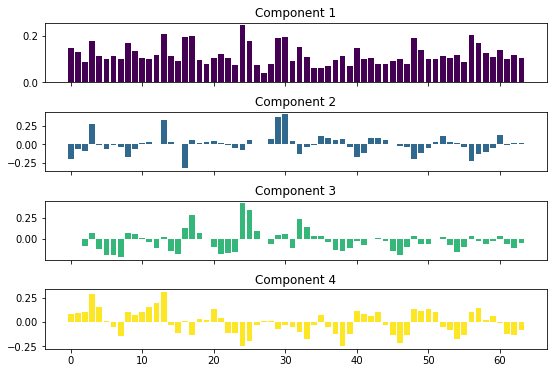

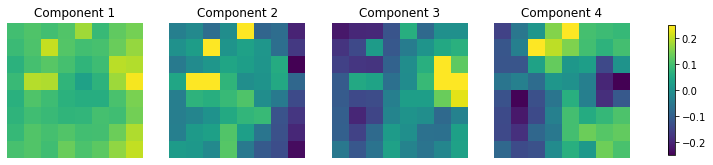

In [247]:
fig = plot_features_bar(pca.components_[:n_features])
fig = plot_features_grid(pca.components_[:n_features],vmin=-0.25,vmax=0.25)

## NMF

In [248]:
nmf = NMF(n_components=n_features, init='random', random_state=42)
nmf.fit(abs(signal_concat).T)

NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0, max_iter=200,
    n_components=4, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

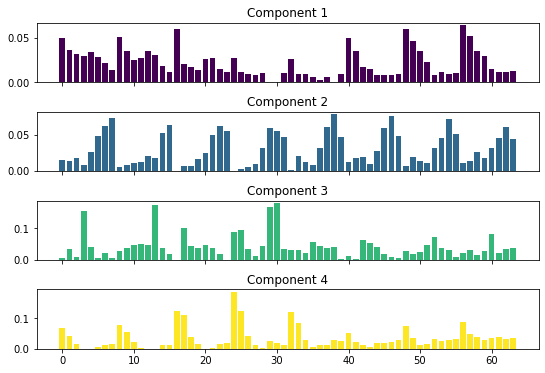

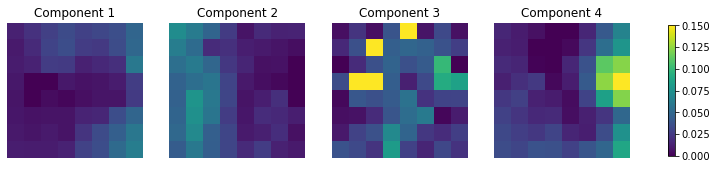

In [250]:
fig = plot_features_bar(nmf.components_[:n_features])
fig = plot_features_grid(nmf.components_[:n_features],vmin=0,vmax=0.15)

## Notes 

These features kinda suck. Think harder. Be smarter. I think the best move is to collect better data. What does "better" mean? 
- more principled collection -- a set of specific tasks?
- lower noise -- check for line noise in a calibration set 

I think I should focus on nonnegative factorizations to be physiologically principled. Negative weights have no real intuitive meaning to me... What nonnegative alternatives are there to NMF? Do I need an alternative factorization? Probably not. 

#### Some stuff about standardizing in PCA: 
*UNTRANSFORMED (RAW) DATA: If you have variables with widely varying scales for raw, untransformed data, that is, caloric intake per day, gene expression, ELISA/Luminex in units of ug/dl, ng/dl, based on several orders of magnitude of protein expression, then use correlation as an input to PCA. However, if all of your data are based on e.g. gene expression from the same platform with similar range and scale, or you are working with log equity asset returns, then using correlation will throw out a tremendous amount of information.*

*You actually don't need to think about the difference of using the correlation matrix 𝐑 or covariance matrix 𝐂 as an input to PCA, but rather, look at the diagonal values of 𝐂 and 𝐑. You may observe a variance of 100 for one variable, and 10 on another -- which are on the diagonal of 𝐂. But when looking at the correlations, the diagonal contains all ones, so the variance of each variable is essentially changed to 1 as you use the 𝐑 matrix.*

*TRANSFORMED DATA: If the data have been transformed via normalization, percentiles, or mean-zero standardization (i.e., 𝑍
-scores), so that the range and scale of all the continuous variables is the same, then you could use the Covariance matrix 𝐂 without any problems. (correlation will mean-zero standardize variables). Recall, however, that these transformations will not remove skewness (i.e., left or right tails in histograms) in your variables prior to running PCA. Typical PCA analysis does not involve removal of skewness; however, some readers may need to remove skewness to meet strict normality constraints.*

*In summary, use the correlation matrix 𝐑 when within-variable range and scale widely differs, and use the covariance matrix 𝐂 to preserve variance if the range and scale of variables is similar or in the same units of measure.*

*SKEWED VARIABLES: If any of the variables are skewed with left or right tails in their histograms, i.e., the Shapiro-Wilk or Lilliefors normality test is significant (𝑃 < 0.05), then there may be some issues if you need to apply the normality assumption. In this case, use the van der Waerden scores (transforms) determined from each variable. The van der Waerden (VDW) score for a single observation is merely the inverse cumulative (standard) normal mapping of the observation's percentile value. For example, say you have 𝑛=100 observations for a continuous variable, you can determine the VDW scores using:*